# Model & Training

Thos codebook will cover the model with the rests and time signatures taken into consideration, and song structure.

In [1]:
# import necessary keras libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, Bidirectional, Embedding, Flatten
from tensorflow.keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras.utils import to_categorical

from tensorflow import keras
from keras_self_attention import SeqSelfAttention

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# import numpy
import numpy as np

# import pickle
import pickle

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) # check if GPU is used

Num GPUs Available:  1


In [3]:
# import notes, note_to_int and song_notes
import pickle

with open('../assets_notes_times/notes', 'rb') as filepath:
    notes = pickle.load(filepath)

with open('../assets_notes_times/note_to_int', 'rb') as filepath:
    note_to_int = pickle.load(filepath)
    
with open('../assets_notes_times/song_notes', 'rb') as filepath:
    song_notes = pickle.load(filepath)

In [4]:
len(notes)

62367

In [5]:
note_to_int

{'unkw': 0,
 '0': 1,
 '0.1': 2,
 '0.1.3': 3,
 '0.1.5': 4,
 '0.1.6': 5,
 '0.2': 6,
 '0.2.3.7': 7,
 '0.2.4.7': 8,
 '0.2.5': 9,
 '0.2.6': 10,
 '0.2.7': 11,
 '0.3': 12,
 '0.3.5': 13,
 '0.3.5.8': 14,
 '0.3.6': 15,
 '0.3.6.8': 16,
 '0.3.6.9': 17,
 '0.3.7': 18,
 '0.4': 19,
 '0.4.5': 20,
 '0.4.6': 21,
 '0.4.7': 22,
 '0.5': 23,
 '0.6': 24,
 '1': 25,
 '1.2': 26,
 '1.2.4.6.8.10': 27,
 '1.2.6': 28,
 '1.2.6.9': 29,
 '1.3': 30,
 '1.3.4.8': 31,
 '1.3.5': 32,
 '1.3.5.8': 33,
 '1.3.6': 34,
 '1.3.7': 35,
 '1.3.8': 36,
 '1.4': 37,
 '1.4.6': 38,
 '1.4.6.8': 39,
 '1.4.6.9': 40,
 '1.4.7': 41,
 '1.4.7.10': 42,
 '1.4.7.9': 43,
 '1.4.8': 44,
 '1.5': 45,
 '1.5.8': 46,
 '1.5.9': 47,
 '1.6': 48,
 '1.7': 49,
 '10': 50,
 '10.0': 51,
 '10.0.2': 52,
 '10.0.2.5': 53,
 '10.0.3': 54,
 '10.0.3.6': 55,
 '10.0.4': 56,
 '10.0.5': 57,
 '10.1': 58,
 '10.1.3': 59,
 '10.1.3.4.6': 60,
 '10.1.3.5.6': 61,
 '10.1.3.6': 62,
 '10.1.4': 63,
 '10.1.4.6': 64,
 '10.1.5': 65,
 '10.11': 66,
 '10.11.1': 67,
 '10.11.1.3': 68,
 '10.11.1.3.4.6

In [6]:
network_input_initial = []
network_output_initial = []

for song in song_notes:

    # Predict the 101th note using 100 notes at a time
    sequence_length = 100

    # create input note sequences and the corresponding next note for training purposes
    for i in range(0, len(song) - sequence_length, 1):
        sequence_in = song[i:i + sequence_length]
        sequence_out = song[i + sequence_length]
        network_input_initial.append([note_to_int[char] for char in sequence_in])
        network_output_initial.append(note_to_int[sequence_out])

In [7]:
input_count = len(network_input_initial)
input_count

53167

In [8]:
# how many unique notes and chords do we have?
n_vocab = len(note_to_int)
n_vocab

383

In [9]:
sequence_length

100

In [10]:
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input_initial, (input_count, sequence_length, 1)) # np.reshape(your array, (desired shape))

In [11]:
network_input.shape

(53167, 100, 1)

In [12]:
network_output = to_categorical(network_output_initial)

In [13]:
network_output.shape[1]

383

In [14]:
n_vocab

383

## Constructing the model

We will use a number of tensorflow libraries to construct the model:


### RNN
RNN(recurrent neural network) is a type of neural network that is commonly used to develop speech recognition and natural language processing models. It remembers the sequence of the data and uses data patterns to give the prediction.<sup>1</sup>

RNN uses feedback loops which help process the sequence of the data. This loop allows the data to be shared to different nodes and predictions according to the gathered information in a process commonly termed as 'memory'.<sup>1</sup>

These loops create the networks that allow RNN to share information, and also, the loop structure allows the neural network to take the sequence of input data. RNN converts an independent variable to a dependent variable for its next layer.<sup>1</sup>

RNNs, however, are prone to 'long-term dependency problem', which occurs over long sequences when connecting previous information to new information.<sup>1</sup>

### LSTM
LSTM(Long short term memory networks) are a special kind of RNN, introduced to avoid the long-term dependency problem.

LSTMs have feedback connections which make them different to more traditional feedforward neural networks. This enables LSTMs to process entire sequences of data without treating each point in the sequence independently, but rather, retaining useful information about previous data in the sequence to help with the processing of new data points. LSTMs are thus very good at processing sequences of data.<sup>2</sup>

Since LSTMs are better at handling long sequences, they are perfect for processing the input of the music dataset.

### Bidirectional
Bidirectional LSTM is the process of making any neural network have the sequence information in both directions backwards (future to past) or forward(past to future).<sup>1</sup>

Passing the input of the music dataset through a Bidirectional LSTM will ensure stronger connections than the standard LSTM.

### Embeddings
Embedding layer enables us to convert each note/chord or duration into a fixed length vector of defined size.
The resultant vector is a dense one with having real values instead of just 0’s and 1’s. The fixed length of word vectors helps us to represent the various elements in a better way along with reduced dimensions.<sup>3</sup>

By passing the input through an Embedding layer, the model can learn which notes/chords or durations are closely related to each other, which will ultimately help with predictions.

### Batch Normalization
BatchNorm take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.<sup>4</sup>

BatchNorm will be used after each hidden layer sequence.

### Activation Functions
- ReLU (Rectified Linear Unit)
    - Avoids and rectifies vanishing gradient problem.<sup>5</sup>
- Softmax
    - Used as the last layer of neural network which calculates the probabilities distribution of the event over 'n' different events. The main advantage of the function is able to handle multiple classes.<sup>5</sup>
    
### Dropout
The Dropout layer randomly sets input units to 0 with a frequency of the specified rate at each step during training time, which helps prevent overfitting.<sup>6</sup>

In [15]:
def create_network(network_input, n_vocab):
#     create the structure of the neural network
    model = Sequential()
    model.add(Embedding(
        n_vocab,
        512,
        input_length=100,
    ))
    model.add(Bidirectional(LSTM(
        512,
        recurrent_dropout=0,
        return_sequences=True
    )))
    model.add(Bidirectional(LSTM(512, return_sequences=True, recurrent_dropout=0,)))
    model.add(Bidirectional(LSTM(512)))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    opt = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

    return model

In [16]:
def callback():
    # Create filepath to store the weights of the various epochs
    filepath = "../weights/weights-{epoch:02d}-{loss:.4f}.hdf5"
    checkpoint = [
        EarlyStopping(
            monitor='loss',
            patience=5, # ensures that model stops training once loss starts to increase
            mode='auto',
            min_delta=0),
        ModelCheckpoint(
            filepath,
            monitor='loss',
            verbose=0,
            save_best_only=True, #save weights only if the epoch results in lower loss
            mode='min'
                    )]
    return [checkpoint]

In [17]:
callbacks_list = callback()
callbacks_list

[[<tensorflow.python.keras.callbacks.EarlyStopping at 0x13c254af220>,

In [18]:
model = create_network(network_input, n_vocab)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 512)          196096    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 1024)         4198400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 1024)         6295552   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2

In [19]:
hist = model.fit(network_input, network_output, epochs=1000, batch_size=128, callbacks=callbacks_list)

Epoch 1/1000
416/416 [==============================] - 147s 313ms/step - loss: 4.0964 - acc: 0.1423
Epoch 2/1000
416/416 [==============================] - 132s 317ms/step - loss: 3.4665 - acc: 0.1809
Epoch 3/1000
416/416 [==============================] - 135s 326ms/step - loss: 3.3015 - acc: 0.2033
Epoch 4/1000
416/416 [==============================] - 134s 323ms/step - loss: 3.0744 - acc: 0.2445
Epoch 5/1000
416/416 [==============================] - 132s 316ms/step - loss: 2.8615 - acc: 0.2846
Epoch 6/1000
416/416 [==============================] - 132s 317ms/step - loss: 2.7326 - acc: 0.3143
Epoch 7/1000
416/416 [==============================] - 132s 317ms/step - loss: 2.4698 - acc: 0.3718
Epoch 8/1000
416/416 [==============================] - 132s 317ms/step - loss: 2.1778 - acc: 0.4417
Epoch 9/1000
416/416 [==============================] - 132s 318ms/step - loss: 1.8850 - acc: 0.5076
Epoch 10/1000
416/416 [==============================] - 132s 317ms/step - loss: 1.6022 - a

In [20]:
import matplotlib.pyplot as plt

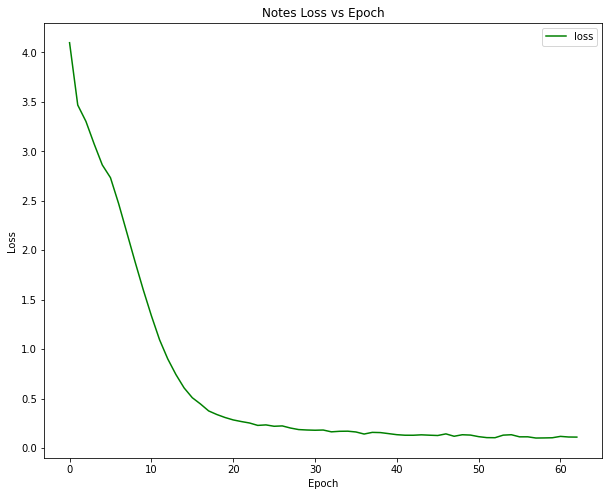

In [52]:
plt.figure(figsize=(10,8))
plt.title('Notes Loss vs Epoch')
plt.plot(hist.epoch, hist.history['loss'], label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

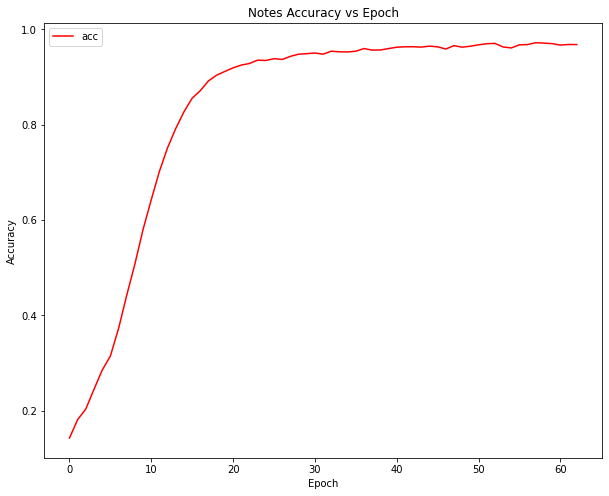

In [53]:
plt.figure(figsize=(10,8))
plt.title('Notes Accuracy vs Epoch')
plt.plot(hist.epoch, hist.history['acc'], label='acc', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

## Do the same for the time

In [30]:
# import time, time_to_int and song_times
import pickle

with open('../assets_notes_times/time', 'rb') as filepath:
    time = pickle.load(filepath)

with open('../assets_notes_times/time_to_int', 'rb') as filepath:
    time_to_int = pickle.load(filepath)
    
with open('../assets_notes_times/song_times', 'rb') as filepath:
    song_times = pickle.load(filepath)

In [31]:
len(time)

62367

In [32]:
time_to_int

{'unkw': 0,
 '0.25': 1,
 '0.5': 2,
 '0.75': 3,
 '1.0': 4,
 '1.25': 5,
 '1.5': 6,
 '1.75': 7,
 '1/12': 8,
 '1/3': 9,
 '1/6': 10,
 '10.0': 11,
 '10.5': 12,
 '10.75': 13,
 '10/3': 14,
 '102.75': 15,
 '104.75': 16,
 '106.5': 17,
 '107.0': 18,
 '107/6': 19,
 '1085/12': 20,
 '109.25': 21,
 '11.75': 22,
 '11/6': 23,
 '110.5': 24,
 '111.0': 25,
 '115.0': 26,
 '115.75': 27,
 '118.5': 28,
 '118.75': 29,
 '119.5': 30,
 '12.0': 31,
 '125/6': 32,
 '126.0': 33,
 '126.5': 34,
 '13.0': 35,
 '13.75': 36,
 '13/3': 37,
 '131.0': 38,
 '131.75': 39,
 '134.0': 40,
 '134.75': 41,
 '135.0': 42,
 '136.75': 43,
 '138.5': 44,
 '138.75': 45,
 '14.5': 46,
 '142.75': 47,
 '143.0': 48,
 '144.75': 49,
 '15.75': 50,
 '150.75': 51,
 '155.25': 52,
 '157.0': 53,
 '159.75': 54,
 '16.0': 55,
 '167.5': 56,
 '168.5': 57,
 '17.0': 58,
 '17.75': 59,
 '17/12': 60,
 '17/6': 61,
 '172/3': 62,
 '175.75': 63,
 '18.0': 64,
 '18.5': 65,
 '19.0': 66,
 '19.75': 67,
 '2.0': 68,
 '2.25': 69,
 '2.5': 70,
 '2.75': 71,
 '2/3': 72,
 '20.0': 

In [33]:
network_input_initial_time = []
network_output_initial_time = []

for times in song_times:

    # Predict the 101th note using 100 notes at a time
    sequence_length = 100

    # create input note sequences and the corresponding next note for training purposes
    for i in range(0, len(times) - sequence_length, 1):
        sequence_in = times[i:i + sequence_length]
        sequence_out = times[i + sequence_length]
        network_input_initial_time.append([time_to_int[char] for char in sequence_in])
        network_output_initial_time.append(time_to_int[sequence_out])

In [34]:
len(time)

62367

In [35]:
input_count_time = len(network_input_initial_time)
input_count_time

53167

In [36]:
# how many unique times do we have?
t_vocab = len(time_to_int)
t_vocab

174

In [37]:
# reshape the input into a format compatible with LSTM layers
network_input_time = np.reshape(network_input_initial_time, (input_count_time, sequence_length, 1)) # np.reshape(your array, (desired shape))
network_input_time.shape

(53167, 100, 1)

In [38]:
network_output_time = to_categorical(network_output_initial_time)
network_output_time.shape

(53167, 174)

In [46]:
#same model architecture as notes
model_time = create_network(network_input_initial, t_vocab)
model_time.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 512)          89088     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 1024)         4198400   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100, 1024)         6295552   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

In [47]:
def callback_time():
    # Create filepath to store the weights of the various epochs
    filepath = "../weights/weights-{epoch:02d}-{loss:.4f}.hdf5"
    checkpoint = [
        EarlyStopping(
            monitor='loss',
            patience=5,
            mode='auto',
            min_delta=0),
        ModelCheckpoint(
            filepath,
            monitor='loss',
            verbose=0,
            save_best_only=True, #save weights only if the epoch results in lower loss
            mode='min'
                    )]
    return [checkpoint]

In [48]:
callbacks_list_time = callback_time()
callbacks_list_time

[[<tensorflow.python.keras.callbacks.EarlyStopping at 0x13ddf3531c0>,

In [49]:
hist_2 = model_time.fit(network_input_time, network_output_time, epochs=1000, batch_size=128, callbacks=callbacks_list_time)

Epoch 1/1000
416/416 [==============================] - 146s 311ms/step - loss: 2.2547 - acc: 0.5106
Epoch 2/1000
416/416 [==============================] - 131s 315ms/step - loss: 1.6315 - acc: 0.5347
Epoch 3/1000
416/416 [==============================] - 133s 321ms/step - loss: 1.5744 - acc: 0.5379
Epoch 4/1000
416/416 [==============================] - 133s 320ms/step - loss: 1.4989 - acc: 0.5487
Epoch 5/1000
416/416 [==============================] - 131s 315ms/step - loss: 1.4243 - acc: 0.5614
Epoch 6/1000
416/416 [==============================] - 131s 315ms/step - loss: 1.3792 - acc: 0.5742
Epoch 7/1000
416/416 [==============================] - 135s 325ms/step - loss: 1.3362 - acc: 0.5839
Epoch 8/1000
416/416 [==============================] - 132s 316ms/step - loss: 1.3239 - acc: 0.5896
Epoch 9/1000
416/416 [==============================] - 131s 316ms/step - loss: 1.2613 - acc: 0.6057
Epoch 10/1000
416/416 [==============================] - 133s 319ms/step - loss: 1.2192 - a

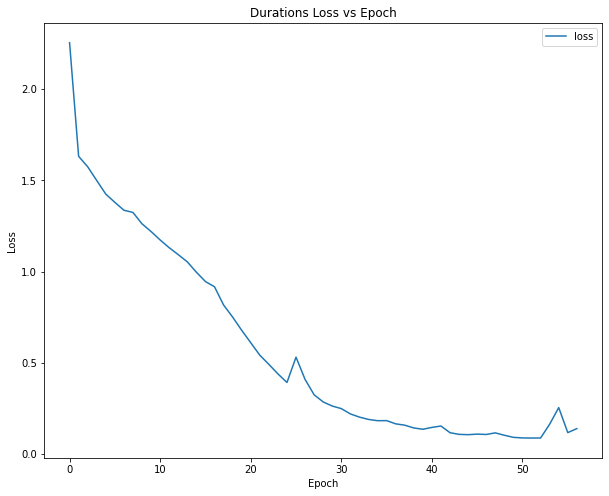

In [54]:
plt.figure(figsize=(10,8))
plt.title('Durations Loss vs Epoch')
plt.plot(hist_2.epoch, hist_2.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

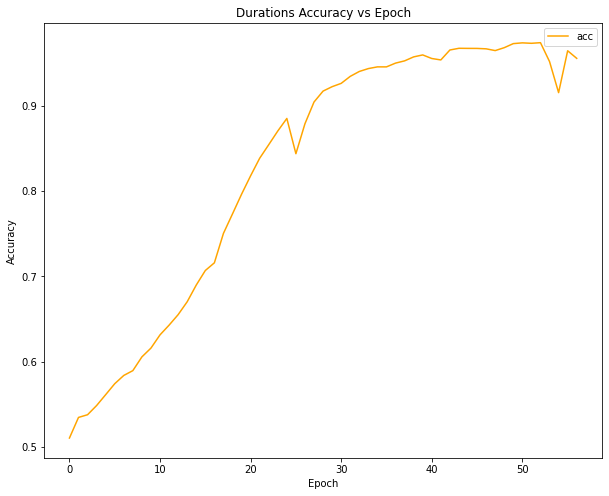

In [55]:
plt.figure(figsize=(10,8))
plt.title('Durations Accuracy vs Epoch')
plt.plot(hist_2.epoch, hist_2.history['acc'], label='acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

## References
1. https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/#:~:text=Bidirectional%20long%2Dshort%20term%20memory,forward(past%20to%20future).
2. https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/#:~:text=Bidirectional%20long%2Dshort%20term%20memory,forward(past%20to%20future).
3. https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce#:~:text=Embedding%20layer%20enables%20us%20to,way%20along%20with%20reduced%20dimensions.
4. https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739#:~:text=Batch%20Norm%20is%20just%20another,of%20the%20next%20hidden%20layer.
5. https://medium.com/@cmukesh8688/activation-functions-sigmoid-tanh-relu-leaky-relu-softmax-50d3778dcea5#:~:text=Generally%20%2C%20we%20use%20ReLU%20in,use%20in%20last%20output%20layer%20.
6. https://keras.io/api/layers/regularization_layers/dropout/#:~:text=The%20Dropout%20layer%20randomly%20sets,over%20all%20inputs%20is%20unchanged.